In [188]:
import json
import os

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sn
from shapely.geometry import Point, LineString
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

tqdm.pandas()

In [85]:
pd.options.display.max_columns = None

# Data loading

### Kornel

In [96]:
# Kornel
data = pd.read_excel('../../data/raw/Ankiety.xlsx', "Wrocław_ankiety+podróże", engine='openpyxl', header=[0,1])
data.columns = [f'{i}_{j}' for i, j in data.columns]
data = data.iloc[0:14241]

### Marcel

In [104]:
# Marcel
kbr_data_path = '../../data/raw/KBR/'
kbr_dir_path = '1_Ankiety_w_gospodarstwach_domowych/'
kbr_file_path = 'Etap_V_1_1_Ankiety_w_gospodarstwach_domowych_Wroclaw.xlsx'
excel_sheet = 'Wrocław_ankiety+podróże'

data = pd.read_excel(os.path.join(kbr_data_path, kbr_dir_path, kbr_file_path), excel_sheet, header=[0,1], engine='openpyxl')

data.columns = [f'{i}_{j}' for i, j in data.columns]
data = data.iloc[0:14241]

if data.shape[1] == len(set(list(data.columns))):
    print('All column names are unique.')
else:
    print('All column names are NOT unique.')

All column names are unique.


In [92]:
# Marcel
kbr_data_path = '../../data/raw/KBR/'
kbr_dir_path = 'Etap_I_II_Wyznaczenie_obszaru_badan_liczby_mieszkancow_i_miejsc_pracy_na_podstawie_kart_SIM/Pliki_GIS_Wyznaczenie_obszaru_badan/2_Podzial_na_rejony/'
kbr_file_path = 'EtapII-REJONY_wroclaw.shp'

regions_file = os.path.join(kbr_data_path, kbr_dir_path, kbr_file_path)
regions = gpd.read_file(regions_file)
regions = regions.to_crs(epsg=3857)

kbr_file_path = 'EtapII-REJONY_wroclaw_centroidy.shp'

regions_centroids_file = os.path.join(kbr_data_path, kbr_dir_path, kbr_file_path)
regions_centroids = gpd.read_file(regions_centroids_file)
regions_centroids = regions_centroids.to_crs(epsg=3857)

In [105]:
data.head()

,Lp_Lp,IDENTYFIKACJA ANKIETY_ID_LOS (numer kwestionariusza),IDENTYFIKACJA ANKIETY_Nr ankietera,IDENTYFIKACJA ANKIETY_Data wypełnienia kwestionariusza,IDENTYFIKACJA ANKIETY_Godzina wypełnienia kwestionariusza,IDENTYFIKACJA ANKIETY_Nr rejonu komunikacyjnego,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Wprowadzenie opłat za wjazd do centrum dla wszystkich pojazdów,"PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Dopuszczenie dojazdu do centrum dla pojazdów, które nie zanieczyszczają środowiska (np. pojazdy elektryczne, hybrydowe lub spełniające najwyższe normy spalania)","PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jaka jest Pana/Pani opinia na temat rozwiązań wspierających kursowanie tramwajów i autobusów, takich jak priorytet przejazdu na skrzyżowaniach oraz wydzielone pasy na jezdniach?",PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Z jakiego środka transportu zbiorowego korzysta Pan/Pani najczęściej?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Dlaczego? \n[tramwaj/autobus],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Dlaczego? [Inne]\n[tramwaj/autobus],"PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jaka jest Pana/Pani opinia na temat rozwoju systemu kolei aglomeracyjnej na terenie Wrocławia i wokół niego (rozbudowa układu torowego, zwiększenie częstotliwości itd.)?",PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia czystość taboru komunikacji zbiorowej we Wrocławiu?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?,PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niekorzystne ustawienia sygnalizacji świetlnej],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zły stan nawierzchni chodników],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zastawianie chodników przez parkujące samochody],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niebezpieczne zachowania kierowców],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zagrożenie ze strony rowerzystów poruszających się chodnikami],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zbyt wysokie krawężniki],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak bieżącego utrzymania czystości/odśnieżania],PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niewystarczająca liczba przejść dla pieszych],"PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wska

In [94]:
regions.head()

,NUMBER,NAME,ZST_0_5,ZST_6_15,ZST_16_19,ZST_20_24,ZST_25_44,ZST_45_WE,ZST_WE_I_W,ZST_SUMA,ZCZ_0_5,ZCZ_6_15,ZCZ_16_19,ZCZ_20_24,ZCZ_25_44,ZCZ_45_WE,ZCZ_WE_I_W,ZCZ_SUMA,GUS_MI,GUS_MI_6_,BD_A_MI_6_,REGON_ZI,BD_A_ZI,geometry
0,22,Komandorska/Swobodna,111.0,200.0,68.0,82.0,670.0,606.0,1412.0,3149.0,3.0,5.0,0.0,10.0,32.0,11.0,3.0,64.0,3213,3102,3202,1255,1200,"POLYGON ((1896088.508 6638289.682, 1896090.449..."
1,23,Centrum PoÅudniowe,101.0,124.0,49.0,81.0,595.0,547.0,812.0,2309.0,3.0,9.0,1.0,7.0,55.0,17.0,3.0,95.0,2404,2303,2377,10258,4750,"POLYGON ((1895696.332 6638631.845, 1895609.850..."
2,24,Stysia,154.0,257.0,74.0,123.0,942.0,825.0,1257.0,3632.0,3.0,23.0,54.0,6.0,34.0,13.0,4.0,137.0,3769,3615,5118,1373,2296,"POLYGON ((1895195.706 6638966.861, 1895023.610..."
3,25,OstrÃ³w Tumski,20.0,26.0,10.0,18.0,219.0,220.0,227.0,740.0,1.0,3.0,1.0,3.0,22.0,10.0,14.0,54.0,794,774,799,413,1479,"POLYGON ((1897793.867 6641122.750, 1897605.051..."
4,26,Szczytnicka,221.0,320.0,139.0,274.0,1375.0,1349.0,1134.0,4812.0,6.0,3.0,3.0,17.0,49.0,13.0,3.0,94.0,4906,4685,4836,1468,1522,"POLYGON ((1898500.766 6641903.438, 1898632.875..."


In [95]:
regions_centroids.head()

,NUMBER,NAME,geometry
0,22,Komandorska/Swobodna,POINT (1895691.084 6638060.201)
1,23,Centrum Południowe,POINT (1895216.845 6638469.484)
2,24,Stysia,POINT (1894784.807 6638834.557)
3,25,Ostrów Tumski,POINT (1897613.196 6641635.311)
4,26,Szczytnicka,POINT (1898512.276 6641616.408)


In [106]:
chosen_cols = [
    # 'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Z jakiego środka transportu zbiorowego korzysta Pan/Pani\xa0najczęściej?',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?\xa0',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak Pan/Pani ocenia\xa0punktualność\xa0komunikacji zbiorowej\xa0we Wrocławiu?\xa0',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i\xa0parkingów rowerowych)?',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niekorzystne ustawienia sygnalizacji świetlnej]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zły stan nawierzchni chodników]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zastawianie chodników przez parkujące samochody]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niebezpieczne zachowania kierowców]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zagrożenie ze strony rowerzystów poruszających się chodnikami]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [zbyt wysokie krawężniki]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak bieżącego utrzymania czystości/odśnieżania]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niewystarczająca liczba przejść dla pieszych]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [uciążliwy ruch kołowy]',
    'PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ_Jakie elementy stanowią dla Pana/Pani największa uciążliwość w codziennych podróżach pieszych po Wrocławiu (można wskazać maksymalnie 3 odpowiedzi) [niewłaściwe oświetlenie ciągów pieszych]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba osób w gospodarstwie domowym [ogółem]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba osób w gospodarstwie domowym [powyżej 6 roku życia]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba środków transportu w gospodarstwie domowym [Samochód prywatny, zarejestrowany na osobę z gosp. domowego]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba środków transportu w gospodarstwie domowym [Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba środków transportu w gospodarstwie domowym [Samochód służbowy]',
    'DANE O GOSPODARSTWIE DOMOWYM_Liczba środków transportu w gospodarstwie domowym [Rower]',
    'DANE O RESPONDENCIE_Przedział wiekowy',
    'DANE O RESPONDENCIE_Płeć',
    # 'DANE O RESPONDENCIE_Zajęcie podstawowe',
    'DANE O RESPONDENCIE_Kondycja fizyczna',
    'DANE O RESPONDENCIE_Opieka nad innymi osobami',
    'DANE O RESPONDENCIE_Posiadanie prawa jazdy kat. B',
    'DANE O RESPONDENCIE_Posiadanie biletu okresowego',
    'DANE O RESPONDENCIE_Posiadanie ulgi na przejazd komunikacją zbiorową we Wrocławiu',
    'OPIS PODRÓŻY "ŹRÓDŁO"_Z jakiego miejsca',
    'OPIS PODRÓŻY "ŹRÓDŁO"_Nr rejonu',
    'OPIS PODRÓŻY "CEL"_Do jakiego miejsca',
    'OPIS PODRÓŻY "CEL"_Nr rejonu',
    '23:59:00_pora dnia',
    '23:59:00_motywacje',
    '23:59:00_środek transportu grupa'
]

data = data[chosen_cols]

data.columns = [
    # 'Z jakiego środka transportu zbiorowego korzysta Pan/Pani najczęściej?',
    'Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?',
    'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?',
    'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?',
    'PIESZO Niekorzystne ustawienia sygnalizacji świetlnej',
    'PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką',
    'PIESZO Zły stan nawierzchni chodników',
    'PIESZO Zastawianie chodników przez parkujące samochody',
    'PIESZO Niebezpieczne zachowania kierowców',
    'PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami',
    'PIESZO Zbyt wysokie krawężniki',
    'PIESZO Brak bieżącego utrzymania czystości/odśnieżania',
    'PIESZO Niewystarczająca liczba przejść dla pieszych',
    'PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)',
    'PIESZO Uciążliwy ruch kołowy',
    'PIESZO Niewłaściwe oświetlenie ciągów pieszych',
    'Liczba osób w gospodarstwie domowym [ogółem]',
    'Liczba osób w gospodarstwie domowym [powyżej 6 roku życia]',
    'Samochód prywatny, zarejestrowany na osobę z gosp. domowego',
    'Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]',
    'Samochód służbowy',
    'Rower',
    'Przedział wiekowy',
    'Płeć',
    # 'Zajęcie podstawowe',
    'Kondycja fizyczna',
    'Opieka nad innymi osobami',
    'Posiadanie prawa jazdy kat. B',
    'Posiadanie biletu okresowego',
    'Posiadanie ulgi na przejazd komunikację zbiorową',
    'ŹRÓDŁO Z jakiego miejsca',
    'ŹRÓDŁO Nr rejonu',
    'CEL Do jakiego miejsca',
    'CEL Nr rejonu',
    'Pora dnia (godzina)',
    'Motywacje (skąd-dokąd)',
    'Środek transportu grupa'
]

In [107]:
data.head()

,Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?,Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?,Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?,PIESZO Niekorzystne ustawienia sygnalizacji świetlnej,PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką,PIESZO Zły stan nawierzchni chodników,PIESZO Zastawianie chodników przez parkujące samochody,PIESZO Niebezpieczne zachowania kierowców,PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami,PIESZO Zbyt wysokie krawężniki,PIESZO Brak bieżącego utrzymania czystości/odśnieżania,PIESZO Niewystarczająca liczba przejść dla pieszych,"PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)",PIESZO Uciążliwy ruch kołowy,PIESZO Niewłaściwe oświetlenie ciągów pieszych,Liczba osób w gospodarstwie domowym [ogółem],Liczba osób w gospodarstwie domowym [powyżej 6 roku życia],"Samochód prywatny, zarejestrowany na osobę z gosp. domowego","Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]",Samochód służbowy,Rower,Przedział wiekowy,Płeć,Kondycja fizyczna,Opieka nad innymi osobami,Posiadanie prawa jazdy kat. B,Posiadanie biletu okresowego,Posiadanie ulgi na przejazd komunikację zbiorową,ŹRÓDŁO Z jakiego miejsca,ŹRÓDŁO Nr rejonu,CEL Do jakiego miejsca,CEL Nr rejonu,Pora dnia (godzina),Motywacje (skąd-dokąd),Środek transportu grupa
0,bardzo dobrze,raczej dobrze,bardzo dobrze,Nie,Nie,Nie,Nie,Nie,Tak,Tak,Nie,Nie,Nie,Tak,Nie,1.0,1.0,0.0,0.0,0.0,1.0,61 i więcej (emeryci kobiety),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,dom,67.0,Inne,68.0,9:00-9:59,dom-Inne,komunikacja samochodowa
1,bardzo dobrze,raczej dobrze,bardzo dobrze,Nie,Nie,Nie,Nie,Nie,Tak,Tak,Nie,Nie,Nie,Tak,Nie,1.0,1.0,0.0,0.0,0.0,1.0,61 i więcej (emeryci kobiety),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,Inne,68.0,dom,67.0,9:00-9:59,Inne-dom,komunikacja samochodowa
2,bardzo dobrze,raczej dobrze,raczej dobrze,Nie,Nie,Nie,Tak,Nie,Nie,Nie,Nie,Tak,Nie,Nie,Nie,2.0,2.0,0.0,1.0,0.0,1.0,20-24 (wiek studencki),Kobieta,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,NaN,NaN,NaN,NaN,NaN,-,NaN
3,bardzo dobrze,raczej dobrze,raczej dobrze,Nie,Nie,Nie,Tak,Nie,Nie,Nie,Nie,Tak,Nie,Nie,Nie,2.0,2.0,0.0,1.0,0.0,1.0,20-24 (wiek studencki),Mężczyzna,dobry stan zdrowia,nie dotyczy,Tak,Tak,0.5,NaN,NaN,NaN,NaN,NaN,-,NaN
4,bardzo dobrze,bardzo dobrze,ani dobrze ani źle,Nie,Tak,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,Nie,2.0,2.0,1.0,0.0,0.0,0.0,61 i więcej (emeryci kobiety),Kobieta,dolegliwości zdrowotne,nie dotyczy,Nie,Nie,0.5,NaN,NaN,NaN,NaN,NaN,-,NaN


In [108]:
data.shape

(14241, 35)

# Data processing

## Drop rows with NaN values and prepare column 'Samochód'

In [109]:
data = data.dropna()

data['Samochód'] = data['Samochód prywatny, zarejestrowany na osobę z gosp. domowego'] + data['Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]'] + data['Samochód służbowy']

data = data.drop(columns=['Samochód prywatny, zarejestrowany na osobę z gosp. domowego', 'Samochód prywatny, nie zarejestrowany na osobę z gosp. domowego [użyczone]', 'Samochód służbowy'])

data.shape

(10626, 33)

## Add column with the number of regions the trip went through

In [110]:
def get_regions_num(source_region, destination_region, plot=False):
    regions_num = 1

    if source_region != destination_region:
        source_centroid = regions_centroids[regions_centroids['NUMBER'] == source_region].iloc[0]['geometry']
        destination_centroid = regions_centroids[regions_centroids['NUMBER'] == destination_region].iloc[0]['geometry']

        line = LineString([source_centroid, destination_centroid])

        travel_through_regions = []
        for i in range(len(regions)):
            if regions.iloc[i]['geometry'].intersects(line):
                travel_through_regions.append(regions.iloc[i]['NUMBER'])
        
        regions_num = len(travel_through_regions)

    if plot and regions_num > 1:
        ax = regions[regions['NUMBER'].isin(travel_through_regions)].plot(figsize=(10,10), alpha=0.5, edgecolor='k')
        ctx.add_basemap(ax)
        ax.set_axis_off()

    return regions_num
    

regions_set = set(regions['NUMBER'].unique())


def add_regions_num(row):
    if (row['ŹRÓDŁO Nr rejonu'] in regions_set) and (row['CEL Nr rejonu'] in regions_set):
        try:
            row['Liczba przebytych rejonów'] = get_regions_num(row['ŹRÓDŁO Nr rejonu'], row['CEL Nr rejonu'])
        except:
            print(row)
    else:
        row['Liczba przebytych rejonów'] = -1

    return row

data = data.progress_apply(add_regions_num, axis=1)

100%|██████████| 10626/10626 [09:54<00:00, 17.87it/s]


In [111]:
data_copy = data

## Features dataframe processing - map string values to numerical

### 'Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?'

In [112]:
data['Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?'].unique()

array(['bardzo dobrze', 'raczej dobrze',
       'nie korzystam z komunikacji zbiorowej', 'raczej źle',
       'ani dobrze ani źle', 'bardzo źle'], dtype=object)

In [113]:
var_map_dict = {
    'bardzo źle': 0,
    'raczej źle': 1,
    'ani dobrze ani źle': 2,
    'nie korzystam z komunikacji zbiorowej': 2,
    'raczej dobrze': 3,
    'bardzo dobrze': 4
}

data.replace({'Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?': var_map_dict}, inplace=True)

### 'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?'

In [114]:
data['Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?'].unique()

array(['raczej dobrze', 'bardzo dobrze', 'raczej źle',
       'ani dobrze ani źle', 'nie korzystam z komunikacji zbiorowej',
       'bardzo źle'], dtype=object)

In [115]:
var_map_dict = {
    'bardzo źle': 0,
    'raczej źle': 1,
    'ani dobrze ani źle': 2,
    'nie korzystam z komunikacji zbiorowej': 2,
    'raczej dobrze': 3,
    'bardzo dobrze': 4
}

data.replace({'Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?': var_map_dict}, inplace=True)

### 'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?'

In [116]:
data['Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?'].unique()

array(['bardzo dobrze',
       'nie korzystam z systemu dróg i parkingów rowerowych',
       'raczej źle', 'raczej dobrze', 'ani dobrze ani źle', 'bardzo źle',
       'nie korzystam z komunikacji zbiorowej'], dtype=object)

In [117]:
var_map_dict = {
    'bardzo źle': 0,
    'raczej źle': 1,
    'ani dobrze ani źle': 2,
    'nie korzystam z komunikacji zbiorowej': 2,
    'nie korzystam z systemu dróg i parkingów rowerowych': 2,
    'raczej dobrze': 3,
    'bardzo dobrze': 4
}

data.replace({'Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?': var_map_dict}, inplace=True)

### 'PIESZO Niekorzystne ustawienia sygnalizacji świetlnej'

In [118]:
data['PIESZO Niekorzystne ustawienia sygnalizacji świetlnej'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [119]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Niekorzystne ustawienia sygnalizacji świetlnej': var_map_dict}, inplace=True)

### 'PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką'

In [120]:
data['PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [121]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką': var_map_dict}, inplace=True)

### 'PIESZO Zły stan nawierzchni chodników'

In [122]:
data['PIESZO Zły stan nawierzchni chodników'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [123]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Zły stan nawierzchni chodników': var_map_dict}, inplace=True)

### PIESZO Zastawianie chodników przez parkujące samochody

In [124]:
data['PIESZO Zastawianie chodników przez parkujące samochody'].unique()

array(['Nie', 'Tak', 'tak', 'nie'], dtype=object)

In [125]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Zastawianie chodników przez parkujące samochody': var_map_dict}, inplace=True)

### PIESZO Niebezpieczne zachowania kierowców

In [126]:
data['PIESZO Niebezpieczne zachowania kierowców'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [127]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Niebezpieczne zachowania kierowców': var_map_dict}, inplace=True)

### 'PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami'

In [128]:
data['PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami'].unique()

array(['Tak', 'Nie', 'nie', 'tak'], dtype=object)

In [129]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami': var_map_dict}, inplace=True)

### 'PIESZO Zbyt wysokie krawężniki'

In [130]:
data['PIESZO Zbyt wysokie krawężniki'].unique()

array(['Tak', 'Nie', 'nie', 'tak'], dtype=object)

In [131]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Zbyt wysokie krawężniki': var_map_dict}, inplace=True)

### 'PIESZO Brak bieżącego utrzymania czystości/odśnieżania'

In [132]:
data['PIESZO Brak bieżącego utrzymania czystości/odśnieżania'].unique()

array(['Nie', 'Tak', 'tak', 'nie'], dtype=object)

In [133]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Brak bieżącego utrzymania czystości/odśnieżania': var_map_dict}, inplace=True)

### 'PIESZO Niewystarczająca liczba przejść dla pieszych'

In [134]:
data['PIESZO Niewystarczająca liczba przejść dla pieszych'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [135]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Niewystarczająca liczba przejść dla pieszych': var_map_dict}, inplace=True)

### 'PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)'

In [136]:
data['PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [137]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)': var_map_dict}, inplace=True)

### 'PIESZO Uciążliwy ruch kołowy'

In [138]:
data['PIESZO Uciążliwy ruch kołowy'].unique()

array(['Tak', 'Nie', 'nie', 'tak'], dtype=object)

In [139]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Uciążliwy ruch kołowy': var_map_dict}, inplace=True)

### 'PIESZO Niewłaściwe oświetlenie ciągów pieszych'

In [140]:
data['PIESZO Niewłaściwe oświetlenie ciągów pieszych'].unique()

array(['Nie', 'Tak', 'nie', 'tak'], dtype=object)

In [141]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'PIESZO Niewłaściwe oświetlenie ciągów pieszych': var_map_dict}, inplace=True)

### 'Przedział wiekowy'

In [142]:
data['Przedział wiekowy'].unique()

array(['61 i więcej (emeryci kobiety)',
       '45-65 (starsi pracownicy mężczyźni)', '25-44 (młodsi pracownicy)',
       '66 i więcej (emeryci mężczyźni)',
       '45-60 (starsi pracownicy kobiety)', '20-24 (wiek studencki)',
       '16-19 (młodzież)', '6-15 (dzieci)'], dtype=object)

In [143]:
var_map_dict = {
    '6-15 (dzieci)': 0,
    '16-19 (młodzież)': 1,
    '20-24 (wiek studencki)': 2,
    '25-44 (młodsi pracownicy)': 3,
    '45-60 (starsi pracownicy kobiety)': 4,
    '45-65 (starsi pracownicy mężczyźni)': 4,
    '61 i więcej (emeryci kobiety)': 5,
    '66 i więcej (emeryci mężczyźni)': 5
}

data.replace({'Przedział wiekowy': var_map_dict}, inplace=True)

### 'Płeć'

In [144]:
data['Płeć'].unique()

array(['Kobieta', 'Mężczyzna'], dtype=object)

In [145]:
var_map_dict = {
    'Mężczyzna': 0,
    'Kobieta': 1
}

data.replace({'Płeć': var_map_dict}, inplace=True)

### 'Kondycja fizyczna'

In [146]:
data['Kondycja fizyczna'].unique()

array(['dobry stan zdrowia',
       'osoba starsza dolegliwości związane z\xa0wiekiem',
       'kłopoty z poruszaniem się', 'dolegliwości zdrowotne', 'Inne',
       'inne'], dtype=object)

In [147]:
var_map_dict = {
    'kłopoty z poruszaniem się': 0,
    'dolegliwości zdrowotne': 0,
    'osoba starsza dolegliwości związane z\xa0wiekiem': 0,
    'Inne': 0,
    'inne': 0,
    'dobry stan zdrowia': 1
}

data.replace({'Kondycja fizyczna': var_map_dict}, inplace=True)

### 'Opieka nad innymi osobami'

In [148]:
data['Opieka nad innymi osobami'].unique()

array(['nie dotyczy', 'opieka nad dzieckiem',
       'opieka nad osobą w podeszłym wieku', 'opieka nad inną osobą'],
      dtype=object)

In [149]:
var_map_dict = {
    'nie dotyczy': 0,
    'opieka nad dzieckiem': 1,
    'opieka nad osobą w podeszłym wieku': 1,
    'opieka nad inną osobą': 1
}

data.replace({'Opieka nad innymi osobami': var_map_dict}, inplace=True)

### 'Posiadanie prawa jazdy kat. B'

In [150]:
data['Posiadanie prawa jazdy kat. B'].unique()

array(['Tak', 'Nie', 'tak'], dtype=object)

In [151]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'Posiadanie prawa jazdy kat. B': var_map_dict}, inplace=True)

### 'Posiadanie biletu okresowego'

In [152]:
data['Posiadanie biletu okresowego'].unique()

array(['Tak', 'Nie', 'tak'], dtype=object)

In [153]:
var_map_dict = {
    'Nie': 0,
    'nie': 0,
    'Tak': 1,
    'tak': 1
}

data.replace({'Posiadanie biletu okresowego': var_map_dict}, inplace=True)

### 'Posiadanie ulgi na przejazd komunikację zbiorową'

In [154]:
data['Posiadanie ulgi na przejazd komunikację zbiorową'].unique()

array([0.5, 1, 'brak ulgi'], dtype=object)

In [155]:
var_map_dict = {
    'brak ulgi': 0,
    0.5: 0.5,
    1: 1,
}

data.replace({'Posiadanie ulgi na przejazd komunikację zbiorową': var_map_dict}, inplace=True)

### 'Pora dnia (godzina)'

In [156]:
sorted(data['Pora dnia (godzina)'].unique())

['0:00-4:59',
 '10:00-10:59',
 '11:00-11:59',
 '12:00-12:59',
 '13:00-13:59',
 '14:00-14:59',
 '15:00-15:59',
 '16:00-16:59',
 '17:00-17:59',
 '18:00-18:59',
 '19:00-19:59',
 '20:00-23:59',
 '5:00-5:59',
 '6:00-6:59',
 '7:00-7:59',
 '8:00-8:59',
 '9:00-9:59']

In [157]:
var_map_dict = {
    '0:00-4:59': 0,         # noc           0-5
    '5:00-5:59': 1,         # rano          5-10
    '6:00-6:59': 1,         # rano          5-10
    '7:00-7:59': 1,         # rano          5-10
    '8:00-8:59': 1,         # rano          5-10
    '9:00-9:59': 1,         # rano          5-10
    '10:00-10:59': 2,       # południe      10-14
    '11:00-11:59': 2,       # południe      10-14
    '12:00-12:59': 2,       # południe      10-14
    '13:00-13:59': 2,       # południe      10-14
    '14:00-14:59': 3,       # popołudnie    14-19
    '15:00-15:59': 3,       # popołudnie    14-19
    '16:00-16:59': 3,       # popołudnie    14-19
    '17:00-17:59': 3,       # popołudnie    14-19
    '18:00-18:59': 3,       # popołudnie    14-19
    '19:00-19:59': 4,       # wieczór       19-0
    '20:00-23:59': 4        # wieczór       19-0
}

data.replace({'Pora dnia (godzina)': var_map_dict}, inplace=True)

### 'Środek transportu grupa'

In [158]:
data['Środek transportu grupa'].unique()

array(['komunikacja samochodowa', 'komunikacja zbiorowa', 'pieszo',
       'rower', 'inne'], dtype=object)

In [159]:
data['Środek transportu grupa'].value_counts()

komunikacja samochodowa    4027
komunikacja zbiorowa       3025
pieszo                     2759
rower                       752
inne                         63
Name: Środek transportu grupa, dtype: int64

In [160]:
drop_inne = True

if drop_inne:
    data = data[data['Środek transportu grupa'] != 'inne']
    var_map_dict = {
        'komunikacja samochodowa': 0,
        'komunikacja zbiorowa': 1,
        'pieszo': 2,
        'rower': 3,
    }
else:
    var_map_dict = {
        'komunikacja samochodowa': 0,
        'komunikacja zbiorowa': 1,
        'pieszo': 2,
        'rower': 3,
        'inne': 4
    }

data.replace({'Środek transportu grupa': var_map_dict}, inplace=True)

### 'CEL Do jakiego miejsca'

In [164]:
data['CEL Do jakiego miejsca'] = data['CEL Do jakiego miejsca'].str.replace('Inne', 'inne')
sorted(data['CEL Do jakiego miejsca'].unique())

['dom', 'inne', 'praca', 'szkoła', 'uczelnia']

In [172]:
data = data.merge(
    pd.get_dummies(data['CEL Do jakiego miejsca'], prefix='CEL'),
    left_index=True, 
    right_index=True
)

## Save data dataframe

In [192]:
out_dir = '../../data/processed/mc/decission_tree'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_file = 'data.csv'
out_path = os.path.join(out_dir, out_file)

out_path

'../../data/processed/mc/decission_tree/data.csv'

In [193]:
data.to_csv(out_path)

# Decission Tree

In [173]:
data.head()

,Jak Pan/Pani ocenia wygodę jazdy pojazdami komunikacji zbiorowej?,Jak Pan/Pani ocenia punktualność komunikacji zbiorowej we Wrocławiu?,Jak ocenia Pan/Pani efekty dotychczasowych działań związanych z rozbudową systemu rowerowego we Wrocławiu (dróg i parkingów rowerowych)?,PIESZO Niekorzystne ustawienia sygnalizacji świetlnej,PIESZO Brak chodników i konieczność poruszania się jezdnią/poboczem/wydeptaną ścieżką,PIESZO Zły stan nawierzchni chodników,PIESZO Zastawianie chodników przez parkujące samochody,PIESZO Niebezpieczne zachowania kierowców,PIESZO Zagrożenie ze strony rowerzystów poruszających się chodnikami,PIESZO Zbyt wysokie krawężniki,PIESZO Brak bieżącego utrzymania czystości/odśnieżania,PIESZO Niewystarczająca liczba przejść dla pieszych,"PIESZO Brak miejsc wypoczynku na trasie dojścia (np. ławki, zieleń)",PIESZO Uciążliwy ruch kołowy,PIESZO Niewłaściwe oświetlenie ciągów pieszych,Liczba osób w gospodarstwie domowym [ogółem],Liczba osób w gospodarstwie domowym [powyżej 6 roku życia],Rower,Przedział wiekowy,Płeć,Kondycja fizyczna,Opieka nad innymi osobami,Posiadanie prawa jazdy kat. B,Posiadanie biletu okresowego,Posiadanie ulgi na przejazd komunikację zbiorową,ŹRÓDŁO Z jakiego miejsca,ŹRÓDŁO Nr rejonu,CEL Do jakiego miejsca,CEL Nr rejonu,Pora dnia (godzina),Motywacje (skąd-dokąd),Środek transportu grupa,Samochód,Liczba przebytych rejonów,CEL_dom,CEL_inne,CEL_praca,CEL_szkoła,CEL_uczelnia
0,4,3,4,0,0,0,0,0,1,1,0,0,0,1,0,1.0,1.0,1.0,5,1,1,0,1,1,0.5,dom,67.0,inne,68.0,1,dom-Inne,0,0.0,4,0,1,0,0,0
1,4,3,4,0,0,0,0,0,1,1,0,0,0,1,0,1.0,1.0,1.0,5,1,1,0,1,1,0.5,Inne,68.0,dom,67.0,1,Inne-dom,0,0.0,4,1,0,0,0,0
5,4,4,4,0,1,0,0,0,0,0,0,0,0,0,0,2.0,2.0,0.0,4,0,1,0,1,0,0.5,dom,67.0,inne,68.0,1,dom-Inne,0,1.0,4,0,1,0,0,0
6,4,4,4,0,1,0,0,0,0,0,0,0,0,0,0,2.0,2.0,0.0,4,0,1,0,1,0,0.5,Inne,68.0,dom,67.0,1,Inne-dom,0,1.0,4,1,0,0,0,0
7,4,3,2,0,0,0,0,1,0,0,0,0,0,0,0,1.0,1.0,0.0,3,1,1,0,1,1,0.5,dom,67.0,inne,29.0,3,dom-Inne,1,0.0,7,0,1,0,0,0


In [174]:
X = data.drop(columns=['Środek transportu grupa', 'ŹRÓDŁO Z jakiego miejsca', 'ŹRÓDŁO Nr rejonu', 'CEL Do jakiego miejsca', 'CEL Nr rejonu', 'Motywacje (skąd-dokąd)'])
y = data['Środek transportu grupa']

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [176]:
clf = DecisionTreeClassifier(random_state=42)

In [177]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [178]:
y_pred = clf.predict(X_test)

In [182]:
data['Środek transportu grupa'].value_counts()

0    4027
1    3025
2    2759
3     752
Name: Środek transportu grupa, dtype: int64

In [181]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1370
           1       0.77      0.78      0.77       993
           2       0.81      0.78      0.79       879
           3       0.53      0.61      0.57       244

    accuracy                           0.78      3486
   macro avg       0.73      0.75      0.74      3486
weighted avg       0.79      0.78      0.78      3486



### Confusion matrix

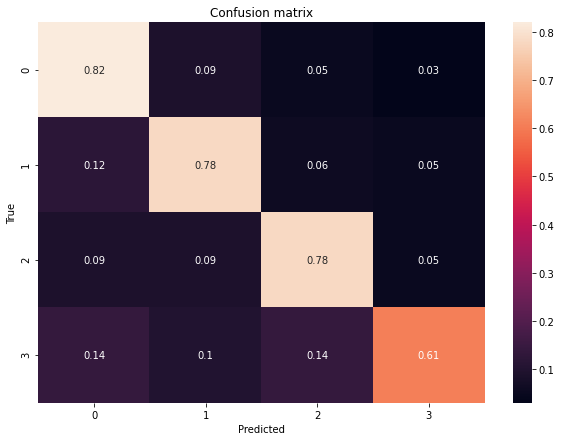

In [187]:
labels = range(4)
# labels.sort()

con_mat = confusion_matrix(y_test, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

df_cm = pd.DataFrame(con_mat_norm,
                     index = labels, 
                     columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [191]:
fig = go.Figure([go.Bar(x=X_train.columns, y=clf.feature_importances_)])
fig.update_layout(
    title='Features importance',
    xaxis={
        'title':"Feature",
    },
    yaxis={
        'title':"Importance",
    }
)
fig.show()